In [399]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [400]:
def train_test_split(X, Y, train_size):

    N = X.shape[0] #assumes data of shape (N,1)

    #shuffle data
    indexes = np.arange(N)
    np.random.seed(42)
    np.random.shuffle(indexes)

    #get indexes
    N_train = int(N*train_size) #train_size is in the range [0,1]
    train_idxs = indexes[:N_train]
    test_idxs = indexes[N_train:]

    #partition data
    return X[train_idxs], X[test_idxs], Y[train_idxs], Y[test_idxs]

def vandermonde(X, k):

    N = X.shape[0] # X is assumed to be (N, d). In this case d=1
    PhiX = np.zeros((N, k))

    for i in range(k):
        PhiX[:, i] = (X**i).flatten() #PhiX[:, i] has shape (N,) while X**i has shape (N,1) => transform X**i to a row

    return PhiX

def loss(PhiX, Y, theta, **kwargs):
    return 0.5 * np.linalg.norm(Y - PhiX@theta, 2)**2 

def grad_loss(PhiX, Y, theta, **kwargs):
    return -PhiX.T @ (Y - PhiX@theta) #shape (K, 1) => column vector 

def compute_error(Y, pred):
    return np.mean((Y - pred)**2) # MSE

In [401]:
def GD(loss, grad_loss, theta0, data, alpha=0.1, epochs=200, early_stopping=False, tolf=1e-4, tolx=1e-4, **kwargs):

    X, Y = data # X.shape (N, d) --- Y.shape (N, 1)

    f_vals = np.zeros((epochs+1,))
    grad_norms = np.zeros((epochs+1,))
    errors = np.zeros((epochs+1,))

    f_vals[0] = loss(X, Y, theta0, **kwargs)
    grad_norms[0] = np.linalg.norm(grad_loss(X, Y, theta0, **kwargs))
    errors[0] = compute_error(Y, X@theta0)

    theta = theta0

    for epoch in tqdm(range(epochs)):

        gradient = grad_loss(X, Y, theta, **kwargs) # shape (d, 1)
        new_theta = theta - alpha * gradient # column vector
        
        # check stopping conditions if we are using early stopping
        if early_stopping==True and ((np.linalg.norm(grad_loss(X, Y, new_theta, **kwargs))<(tolf*np.linalg.norm(theta))) or (np.linalg.norm(new_theta-theta)<tolx)):
            break

        #update current theta
        theta = new_theta

        # append values for plots
        f_vals[epoch+1] = loss(X, Y,theta, **kwargs)
        grad_norms[epoch+1] = np.linalg.norm(gradient)
        errors[epoch+1] = compute_error(Y, X@theta)

    return theta, f_vals, grad_norms,errors, epoch

In [402]:
def SGD(loss, grad_loss, theta0, data, alpha=0.1, epochs=50, batch_size=10, early_stopping=False, tolf=1e-4, tolx=1e-4, **kwargs):

    X, Y = data # X.shape (N, d) --- Y.shape (N, 1)
    N = X.shape[0]
    idxs = np.arange(0, N)

    loss_vals = np.zeros((epochs+1,))
    grad_norms = np.zeros((epochs+1,))
    errors = np.zeros((epochs+1,))

    loss_vals[0] = loss(X, Y, theta0, **kwargs)
    grad_norms[0] = np.linalg.norm(grad_loss(X, Y, theta0, **kwargs))
    errors[0] = compute_error(Y, X@theta0)

    theta = theta0

    stop = False # stop is a boolean function to break the outer loop
    for epoch in tqdm(range(epochs)): #iter over epochs
        if stop: #end the training process if stopping condition has occurred
            break
        np.random.shuffle(idxs)
        grad_loss_vec = []

        for batch_start in range(0, N, batch_size): #iter over batches within an epoch

            batch_end = min(batch_start + batch_size, N)
            batch_idxs = idxs[batch_start:batch_end]
            minibatchX = X[batch_idxs]
            minibatchY = Y[batch_idxs]

            gradient = grad_loss(minibatchX, minibatchY, theta, **kwargs)
            new_theta = theta - alpha * gradient

            if early_stopping==True and ((np.linalg.norm(grad_loss(X, Y, new_theta, **kwargs))<(tolf*np.linalg.norm(theta))) or (np.linalg.norm(new_theta-theta)<tolx)):
                stop = True #stop the iteration over thee epoches at the beginning of the next epoch
                break

            theta = new_theta

            grad_loss_vec.append(np.linalg.norm(gradient, 2))

        loss_vals[epoch+1] = loss(X, Y, theta, **kwargs)
        grad_norms[epoch+1] = np.mean(grad_loss_vec)
        errors[epoch+1] = compute_error(Y, X@theta)

    return theta, loss_vals, grad_norms, errors, epoch

In [403]:
def cholesky(PhiX, Y):
    L = np.linalg.cholesky(PhiX.T @ PhiX) 
    z = np.linalg.solve(L, PhiX.T@Y)
    theta = np.linalg.solve(L.T, z)
    return theta

* For a given value of $K$, write three Python functions computing $\theta_{MLE}$, i.e. the optimal parameters obtained by optimizing the MLE-related loss function with Gaussian assumption on the likelihood $p_\theta(y | x)$, by Gradient Descent, Stochastic Gradient Descent (with a `batch_size` = 5), and Normal Equations method with Cholesky Decomposition.

In [445]:
df = pd.read_csv("./poly_regression_large.csv")
X, Y = df["x"].to_numpy().reshape(-1,1), df["y"].to_numpy().reshape(-1,1) #shape (1000,1) --> columns
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.8) #shapes (N,1)

K = 6

PhiX = vandermonde(Xtrain, K) #shape (N,k)
#PhiX = np.vander(Xtrain.ravel(), N=K, increasing=True)

theta0 = np.zeros((K, 1)) #column vector

theta_gd, loss_gd, grad_gd, error_gd, epoch_gd = GD(
    loss, 
    grad_loss, 
    data=(PhiX,Ytrain), 
    epochs=5000, 
    theta0=theta0, 
    alpha=0.001, 
    early_stopping=True,
    tolf=1e-6,
    tolx=1e-6
)

theta_sgd, loss_sgd, grad_sgd, error_sgd, epoch_sgd = SGD(
    loss, 
    grad_loss, 
    data=(PhiX,Ytrain), 
    batch_size=5, 
    epochs=5000, 
    alpha=0.001, 
    theta0=theta0, 
    early_stopping=True,
    tolf=1e-6,
    tolx=1e-6
)

theta_cholesky = cholesky(PhiX, Ytrain)

 78%|███████▊  | 3885/5000 [00:16<00:04, 235.92it/s]


* Compare the performance of the three regression model computed above. In particular, if $(X_{test}, Y_{test})$ is the test set from the `poly_regression_large.csv` dataset, for each of the model, compute:

  $$
  Err = \frac{1}{N_{test}} \sum_{i=1}^{N_{test}} (f_\theta(x^i) - y^i)^2,
  $$

  where $N_{test}$ is the number of elements in the test set, $(x^i, y^i)$ are the input and output elements in the test set. Comment the performance of the three models. 

In [446]:
PhiX_test = vandermonde(Xtest, K)
test_err_gd = compute_error(Ytest, PhiX_test@theta_gd)
test_err_sgd = compute_error(Ytest, PhiX_test@theta_sgd)
test_err_cho = compute_error(Ytest, PhiX_test@theta_cholesky)
print(f"Test MSE GD: {test_err_gd}\nTest MSE SGD: {test_err_sgd}\nTest MSE Cholesky: {test_err_cho}")

Test MSE GD: 0.00971010047760351
Test MSE SGD: 0.009703817960597794
Test MSE Cholesky: 0.009844990396114582


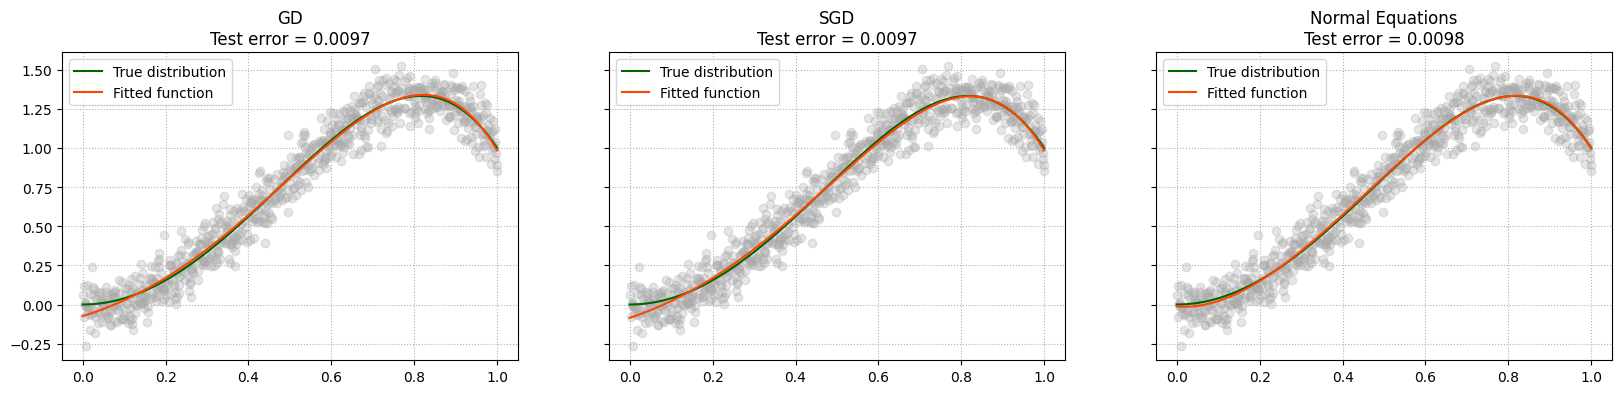

In [447]:
fig, axs = plt.subplots(figsize=(20,4) ,ncols=3, sharey=True)
PhiX_test = vandermonde(Xtest, K)

ax = axs[0]
ax.set_title(f'GD\nTest error = {test_err_gd:.4f}')
ax.scatter(Xtrain, Ytrain, color='darkgrey', alpha=0.3)
ax.grid(linestyle=':')
ax.plot(X, 4*X**2 - 3*X**4, color='darkgreen', label='True distribution')
ax.plot(np.linspace(0,1, 200), vandermonde(np.linspace(0,1,200), K)@theta_gd, color='orangered', label='Fitted function')
ax.legend()

ax = axs[1]
ax.set_title(f'SGD\nTest error = {test_err_sgd:.4f}')
ax.scatter(Xtrain, Ytrain, color='darkgrey', alpha=0.3)
ax.grid(linestyle=':')
ax.plot(X, 4*X**2 - 3*X**4, color='darkgreen', label='True distribution')
ax.plot(np.linspace(0,1, 200), vandermonde(np.linspace(0,1,200), K)@theta_sgd, color='orangered', label='Fitted function')
ax.legend()

ax = axs[2]
ax.set_title(f'Normal Equations\nTest error = {test_err_cho:.4f}')
ax.scatter(Xtrain, Ytrain, color='darkgrey', alpha=0.3)
ax.grid(linestyle=':')
ax.plot(X, 4*X**2 - 3*X**4, color='darkgreen', label='True distribution')
ax.plot(np.linspace(0,1, 200), vandermonde(np.linspace(0,1,200), K)@theta_cholesky, color='orangered', label='Fitted function')
ax.legend()

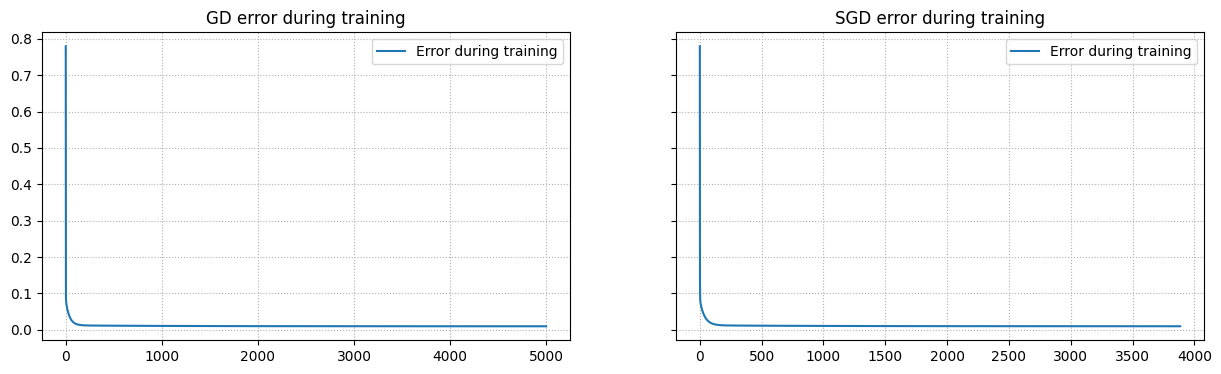

In [451]:
fig, axs = plt.subplots(figsize=(15,4) ,ncols=2, sharey=True)

ax = axs[0]
ax.set_title(f'GD error during training')
ax.plot(error_gd[error_gd!=0], label='Error during training')
ax.grid(linestyle=':')
ax.legend()

ax = axs[1]
ax.set_title(f'SGD error during training')
ax.plot(error_sgd[error_sgd!=0], label='Error during training')
ax.grid(linestyle=':')
ax.legend()

As we can see from the experiments above, all three methods work very well since they show very low test error. However, even though the test error is almost the same for all three methods, the function estimated by the normal equations better resembles the true function from which the data were generated. Furthermore, tolf and tolx were carefully selected to avoid underfitting. Indeed, too high values ​​of tolf and tolf lead to good functions (in the sense that the test error is very low) but they do not fit the data well. Apparently, we can stop training after very few epochs but this would result in a very poor approximation of the true function.

* For different values of $K$, plot the training datapoints and the test datapoints with different colors and visualize (as a continuous line) the three learned regression model $f_\theta(x)$. Comment the results.


Training GD and SGD for k = 3


100%|██████████| 5000/5000 [00:22<00:00, 218.27it/s]



Training GD and SGD for k = 4


 91%|█████████ | 4540/5000 [00:17<00:01, 253.39it/s]



Training GD and SGD for k = 5


 56%|█████▌    | 2782/5000 [00:11<00:09, 239.34it/s]



Training GD and SGD for k = 6


100%|██████████| 5000/5000 [00:21<00:00, 236.77it/s]



Training GD and SGD for k = 7


  5%|▌         | 266/5000 [00:01<00:20, 230.39it/s]



Training GD and SGD for k = 8


 87%|████████▋ | 4346/5000 [00:17<00:02, 243.78it/s]



Training GD and SGD for k = 10


 77%|███████▋  | 3847/5000 [00:17<00:05, 223.66it/s]



Training GD and SGD for k = 12


 48%|████▊     | 2418/5000 [00:30<00:32, 79.97it/s] 


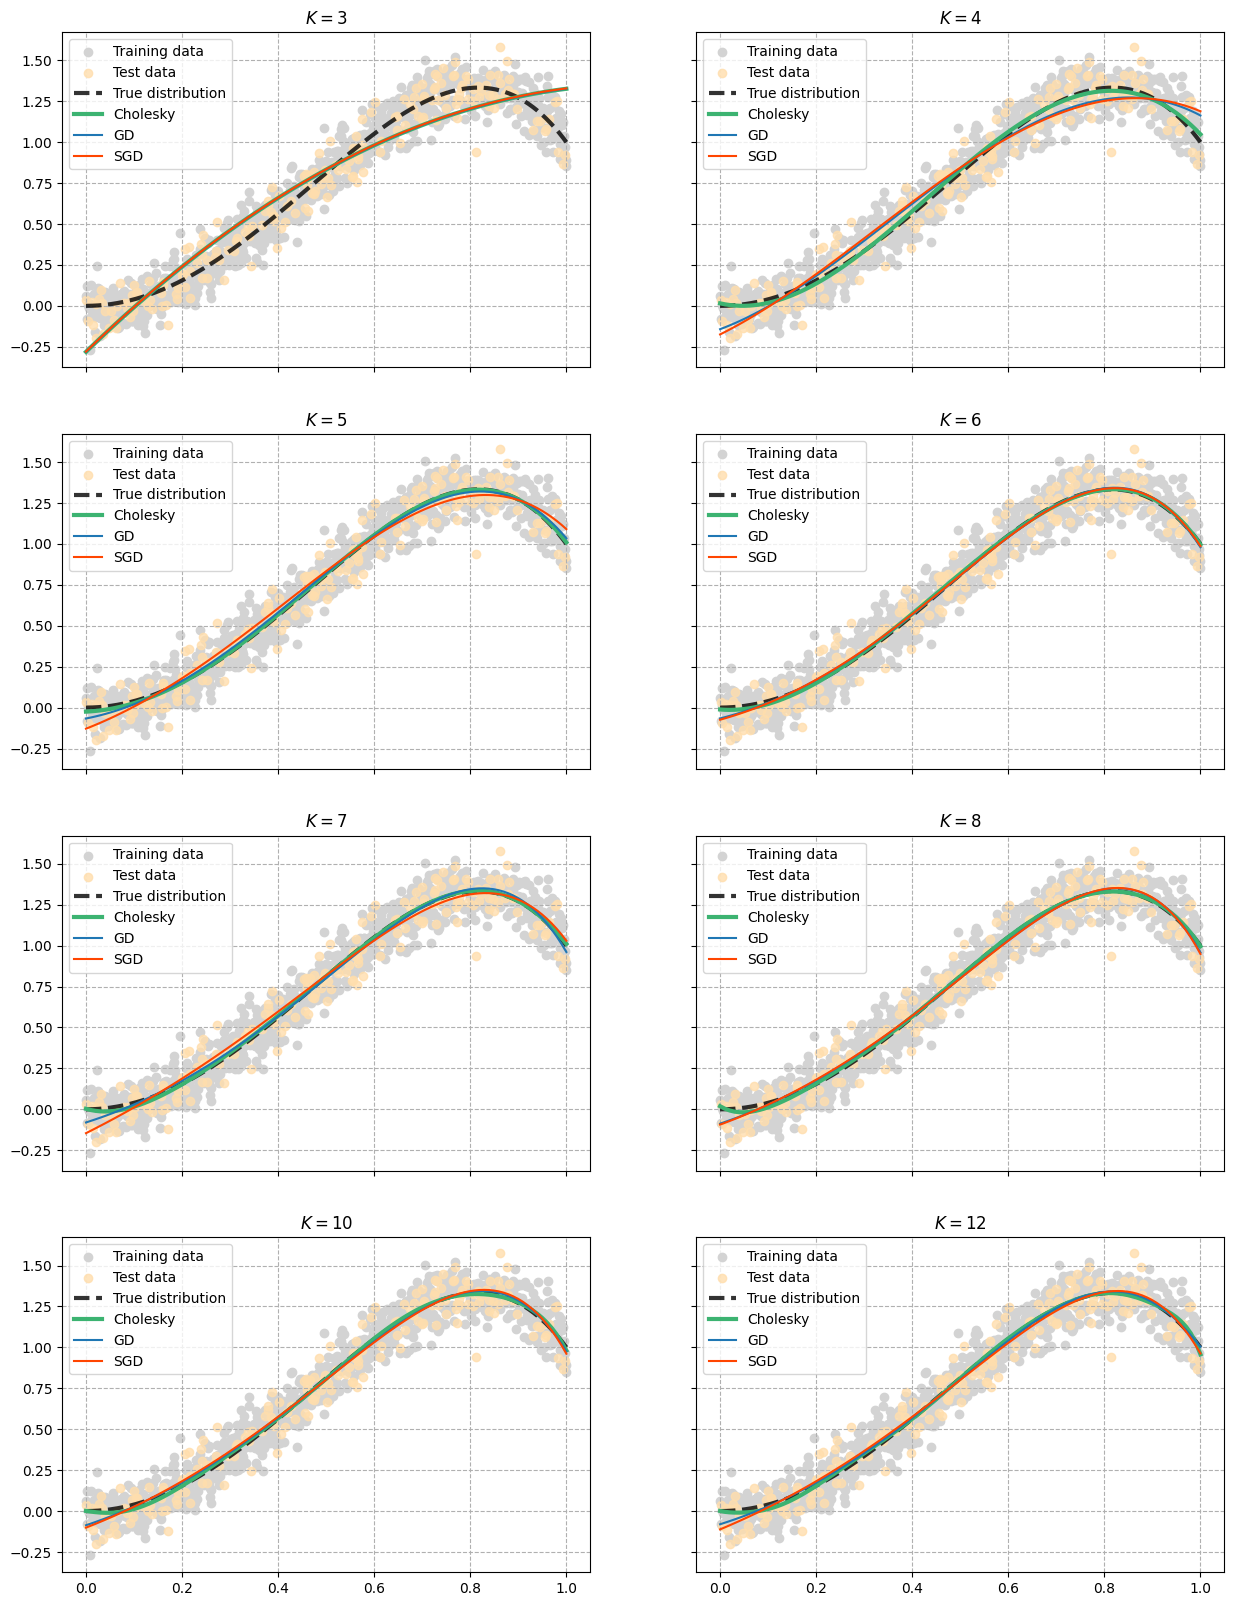

In [455]:
k_vals = np.array([3,4,5,6,7,8,10,12])
nrows = 4
ncols = 2
theta_vals = []

fig, axs = plt.subplots(figsize=(15,20), ncols=ncols, nrows=nrows, sharex=True, sharey=True)
iter = 0
for i in range(nrows):
    for j in range(ncols):

        k = k_vals[iter]
        print(f'\nTraining GD and SGD for k = {k}')
        PhiX = vandermonde(Xtrain, k) #shape (N,k)
        theta0 = np.zeros((k, 1)) #column vector

        theta_gd, loss_gd, grad_gd,error_gd, epoch_gd = GD(
            loss, 
            grad_loss, 
            data=(PhiX,Ytrain), 
            epochs=7000, 
            theta0=theta0, 
            alpha=0.001, 
            early_stopping=True, 
            tolf=1e-6, 
            tolx=1e-6
        )

        theta_sgd, loss_sgd, grad_sgd, error_sgd, epoch_sgd = SGD(
            loss, 
            grad_loss, 
            data=(PhiX,Ytrain), 
            batch_size=5, 
            epochs=5000, 
            alpha=0.001, 
            theta0=theta0, 
            early_stopping=True, 
            tolf=1e-6, 
            tolx=1e-6
        )
        
        theta_cholesky = cholesky(PhiX, Ytrain)

        theta_vals.append([theta_gd, theta_sgd, theta_cholesky])

        ax = axs[i][j]
        ax.scatter(Xtrain, Ytrain, color='lightgray', label='Training data', alpha=1)
        ax.scatter(Xtest, Ytest, color='navajowhite', label='Test data', alpha=0.8)
        ax.plot(X, 4*X**2 - 3*X**4, color='black', label='True distribution', linewidth=3, alpha=0.8, linestyle='--')
        ax.plot(np.linspace(0,1, 100), vandermonde(np.linspace(0,1,100), k)@theta_cholesky, color='mediumseagreen', label='Cholesky', linewidth=3)
        ax.plot(np.linspace(0,1, 100), vandermonde(np.linspace(0,1,100), k)@theta_gd, color='tab:blue', label='GD')
        ax.plot(np.linspace(0,1, 100), vandermonde(np.linspace(0,1,100), k)@theta_sgd, color='orangered', label='SGD')
        ax.set_title(f"$K = {k}$")
        ax.grid(linestyle='--')
        ax.legend()

        iter += 1

For $k = 3$ all the three methods provide the same curve. The curve predicted underfits the data, meaning that it is not flexible enough to capture the complexity of the data. With $k = 4$, GD and SGD still underfitting the data while the curve predicted by Normal Equations resambles pretty well the data. The best configuration probably is for $k = 6$: all the three methods provide approximatively the same curve (maybe Normal equations method is slightely better). For higher values of $k$ (for $k \ge 8$ for example), the three methods seem to "overfit" a little bit especially Normal equations method

* For increasing values of $K$, compute the training and test error as discussed above. Plot the two errors with respect to $K$. Comment the results.

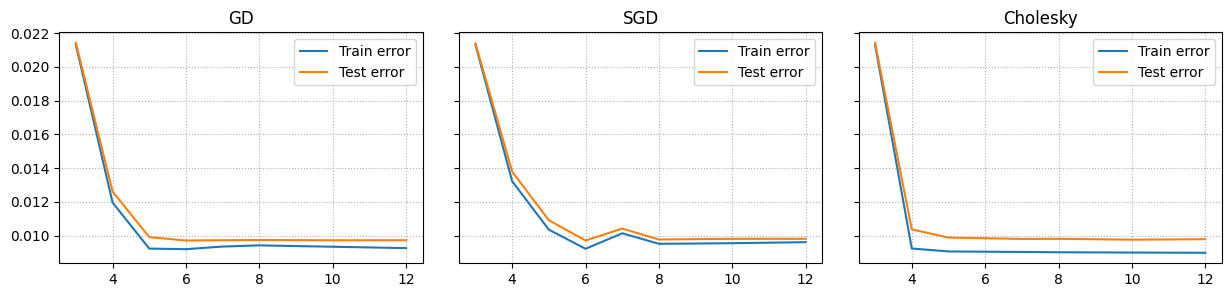

In [456]:
test_err_gd = []
test_err_sgd = []
test_err_cho = []

train_err_gd = []
train_err_sgd = []
train_err_cho = []

iter = 0
k_vals = np.array([3,4,5,6,7,8,10,12])

ncols = 3
nrows = 1

for theta_gd, theta_sgd, theta_cho in theta_vals:
    k = k_vals[iter]
    test_err_gd.append(compute_error(Ytest, vandermonde(Xtest, k)@theta_gd))
    test_err_sgd.append(compute_error(Ytest, vandermonde(Xtest, k)@theta_sgd))
    test_err_cho.append(compute_error(Ytest, vandermonde(Xtest, k)@theta_cho))

    train_err_gd.append(compute_error(Ytrain, vandermonde(Xtrain, k)@theta_gd))
    train_err_sgd.append(compute_error(Ytrain, vandermonde(Xtrain, k)@theta_sgd))
    train_err_cho.append(compute_error(Ytrain, vandermonde(Xtrain, k)@theta_cho))

    iter += 1

fig, axs = plt.subplots(figsize=(15,3), ncols=ncols, nrows=nrows, sharey=True)
fig.subplots_adjust(wspace=0.1)

ax = axs[0]
ax.plot(k_vals, train_err_gd, label='Train error')
ax.plot(k_vals, test_err_gd, label='Test error')
ax.set_title('GD')
ax.grid(linestyle=':')
ax.legend()

ax = axs[1]
ax.plot(k_vals, train_err_sgd, label='Train error')
ax.plot(k_vals, test_err_sgd, label='Test error')
ax.set_title('SGD')
ax.grid(linestyle=':')
ax.legend()

ax = axs[2]
ax.plot(k_vals, train_err_cho, label='Train error')
ax.plot(k_vals, test_err_cho, label='Test error')
ax.set_title('Cholesky')
ax.grid(linestyle=':')
ax.legend()


All the three methods have a similar behavior: they have high error valus for smaller values of k. Normal equations is the method with the fastest convergenge w.r.t. $k$, in the sense that, even for $k=4$, it has an acceptable test error value. For all the methods, strating from $k=6$ both the test error and the train error reaches a plateau, meaning that a degree of the polynomial function greater than 6 is not necessary. The error of SGD reaches the minimum for $k=6$ and then slightely increases suggesting a little overfitting. Moreover, it oscillates and this is due to the stochastic nature of SGD.

In [462]:
def loss_map(PhiX, Y, theta, **kwargs):
    lamb = kwargs['lamb']
    return 0.5 * np.linalg.norm(Y - PhiX@theta, 2)**2  + 0.5 * lamb * np.linalg.norm(theta)**2

def grad_loss_map(PhiX, Y, theta, **kwargs):
    lamb = kwargs['lamb']
    return -PhiX.T @ (Y - PhiX@theta) + lamb * theta #shape (K, 1) => column vector 

Repeat the same experiments by considering the MAP formulation with Gaussian assumption on the prior term $p(\theta)$. Set $K = 8$ and test different values of $\lambda > 0$ in the experiments.

In [463]:
df = pd.read_csv("./poly_regression_large.csv")
X, Y = df["x"].to_numpy().reshape(-1,1), df["y"].to_numpy().reshape(-1,1) #shape (1000,1) --> columns
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.8) #shapes (N,1)

K = 8

PhiX = vandermonde(Xtrain, K) #shape (N,k)
#PhiX = np.vander(Xtrain, N=K, increasing=True)
theta0 = np.zeros((K, 1)) #column vector

theta_gd, loss_gd, grad_gd,error_gd, epoch_gd = GD(
    loss_map, 
    grad_loss_map, 
    data=(PhiX,Ytrain), 
    epochs=20000, 
    theta0=theta0, 
    alpha=0.001, 
    lamb=0.01, 
    early_stopping=True,
    tolf=1e-5,
    tolx=1e-5
)

theta_sgd, loss_sgd, grad_sgd, error_sgd, epoch_sgd = SGD(
    loss_map, 
    grad_loss_map, 
    data=(PhiX,Ytrain), 
    batch_size=10, 
    epochs=20000, 
    alpha=0.001, 
    lamb=0.01, 
    theta0=theta0, 
    early_stopping=True,
    tolf=1e-5,
    tolx=1e-5
)

theta_cholesky = cholesky(PhiX, Ytrain)


  2%|▏         | 375/20000 [00:00<00:44, 445.20it/s]


In [464]:
PhiX_test = vandermonde(Xtest, K)
test_err_gd = compute_error(Ytest, PhiX_test@theta_gd)
test_err_sgd = compute_error(Ytest, PhiX_test@theta_sgd)
test_err_cho = compute_error(Ytest, PhiX_test@theta_cholesky)
print(f"Test MSE GD: {test_err_gd}\nTest MSE SGD: {test_err_sgd}\nTest MSE Cholesky: {test_err_cho}")

Test MSE GD: 0.009702565942922842
Test MSE SGD: 0.01006650267760104
Test MSE Cholesky: 0.009810708635243658


* Compare the different values of $\lambda > 0$ tested,


Training GD and SGD for lambda = 0


  1%|          | 138/20000 [00:00<00:47, 420.33it/s]



Training GD and SGD for lambda = 0.0001


  1%|          | 178/20000 [00:00<00:44, 449.35it/s]



Training GD and SGD for lambda = 0.001


  1%|          | 248/20000 [00:00<00:43, 450.88it/s]



Training GD and SGD for lambda = 0.01


  1%|          | 182/20000 [00:00<00:43, 453.65it/s]



Training GD and SGD for lambda = 0.1


 10%|█         | 2077/20000 [00:04<00:39, 451.66it/s]



Training GD and SGD for lambda = 0.5


 48%|████▊     | 9629/20000 [00:21<00:23, 450.09it/s]



Training GD and SGD for lambda = 1


100%|██████████| 20000/20000 [00:45<00:00, 440.94it/s]



Training GD and SGD for lambda = 2


 23%|██▎       | 4517/20000 [00:10<00:36, 425.42it/s]



Training GD and SGD for lambda = 5


 40%|███▉      | 7956/20000 [00:18<00:28, 423.36it/s]


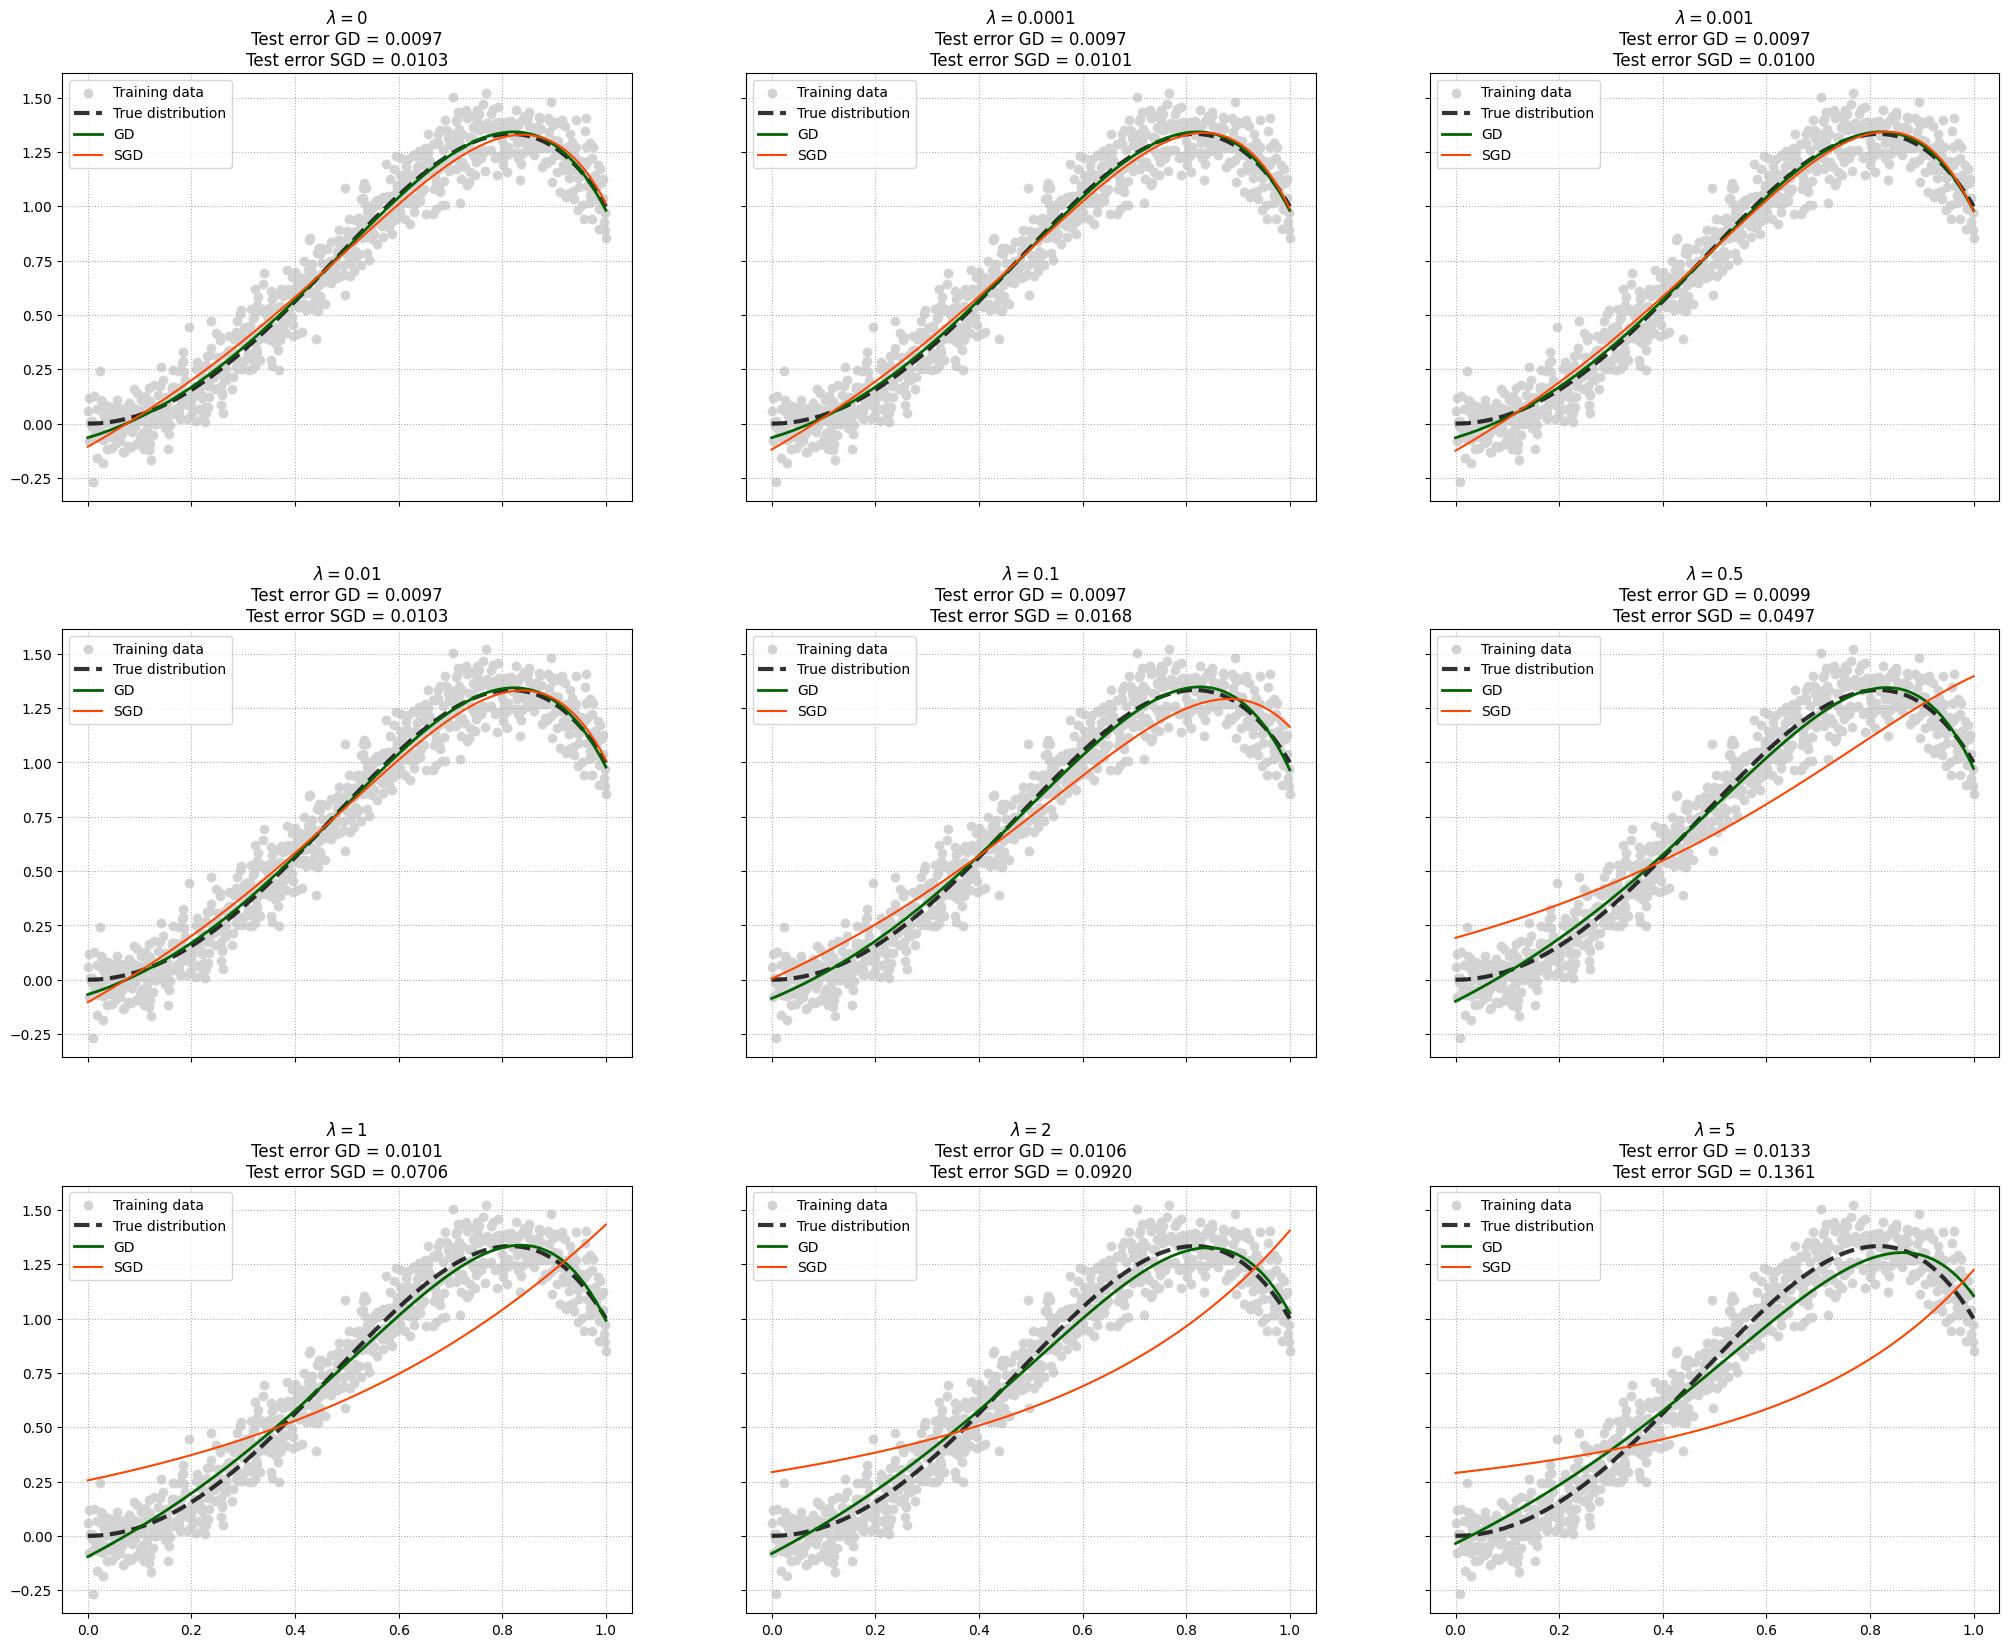

In [465]:
lambda_vals = [0, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 2, 5]
nrows = 3
ncols = 3
k = 8
PhiX = vandermonde(Xtrain, k) #shape (N,k)
theta0 = np.zeros((k, 1)) #column vector

theta_vals_gd = []
theta_vals_sgd = []

test_errs_gd = []
test_errs_sgd = []

train_errs_gd = []
train_errs_sgd = []

fig, axs = plt.subplots(figsize=(25,20), ncols=ncols, nrows=nrows, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3)

iter = 0
for i in range(nrows):
    for j in range(ncols):

        print(f'\nTraining GD and SGD for lambda = {lambda_vals[iter]}')
        
        theta_gd, loss_gd, grad_gd,error_gd, epoch_gd = GD(
            loss_map, 
            grad_loss_map, 
            data=(PhiX,Ytrain), 
            epochs=20000, 
            theta0=theta0, 
            alpha=0.001, 
            lamb=lambda_vals[iter], 
            early_stopping=True,
            tolf=1e-5,
            tolx=1e-5
        )

        theta_sgd, loss_sgd, grad_sgd, error_sgd, epoch_sgd = SGD(
            loss_map, 
            grad_loss_map, 
            data=(PhiX,Ytrain), 
            batch_size=10, 
            epochs=20000, 
            alpha=0.001, 
            lamb=lambda_vals[iter], 
            theta0=theta0, 
            early_stopping=True,
            tolf=1e-5,
            tolx=1e-5
        )

        theta_vals_gd.append(theta_gd)
        theta_vals_sgd.append(theta_sgd)
        train_errs_gd.append(compute_error(Ytrain, PhiX@theta_gd))
        train_errs_sgd.append(compute_error(Ytrain, PhiX@theta_sgd))

        PhiX_test = vandermonde(Xtest, k)
        test_err_gd = compute_error(Ytest, PhiX_test@theta_gd)
        test_errs_gd.append(test_err_gd)

        test_err_sgd = compute_error(Ytest, PhiX_test@theta_sgd)
        test_errs_sgd.append(test_err_sgd)
        
        ax = axs[i][j]
        ax.set_title(f'$\lambda = {lambda_vals[iter]}$\nTest error GD = {test_err_gd:.4f}\nTest error SGD = {test_err_sgd:.4f}')
        ax.scatter(Xtrain, Ytrain, color='lightgray', label='Training data', alpha=1)
        ax.plot(X, 4*X**2 - 3*X**4, color='black', label='True distribution', linewidth=3, alpha=0.8, linestyle='--')
        ax.plot(np.linspace(0,1, 100), vandermonde(np.linspace(0,1,100), k)@theta_gd, color='darkgreen', label='GD', linewidth=2)
        ax.plot(np.linspace(0,1, 100), vandermonde(np.linspace(0,1,100), k)@theta_sgd, color='orangered', label='SGD')
        ax.legend()
        ax.grid(linestyle=':')
        
        iter += 1


MAP can be considered as a form of regularization for MLE. Regularization is a set of methods for reducing overfitting of a model. Since MLE (MAP with $\lambda=0$) doesn't suffer of overfitting, MAP with high valus of $\lambda$ leads to underfitted models. As we can see from the graph above, for small values of $\lambda$ (that is $\lambda\le 0.1$) the fitted curve approximate pretty well the data. This is not true for highr values of $\lambda$. This phenomenon is more accentuated on SGD because SGD uses a small batch, so each time the loss is computed the term $\lambda || \theta ||_1$ dominates over the term $\frac{1}{2} || \Phi(X)\theta - Y ||_2^2$

- Compare the three optimization method used to obtain $\theta_{MAP}$ (i.e. GD, SGD and Normal Equations),

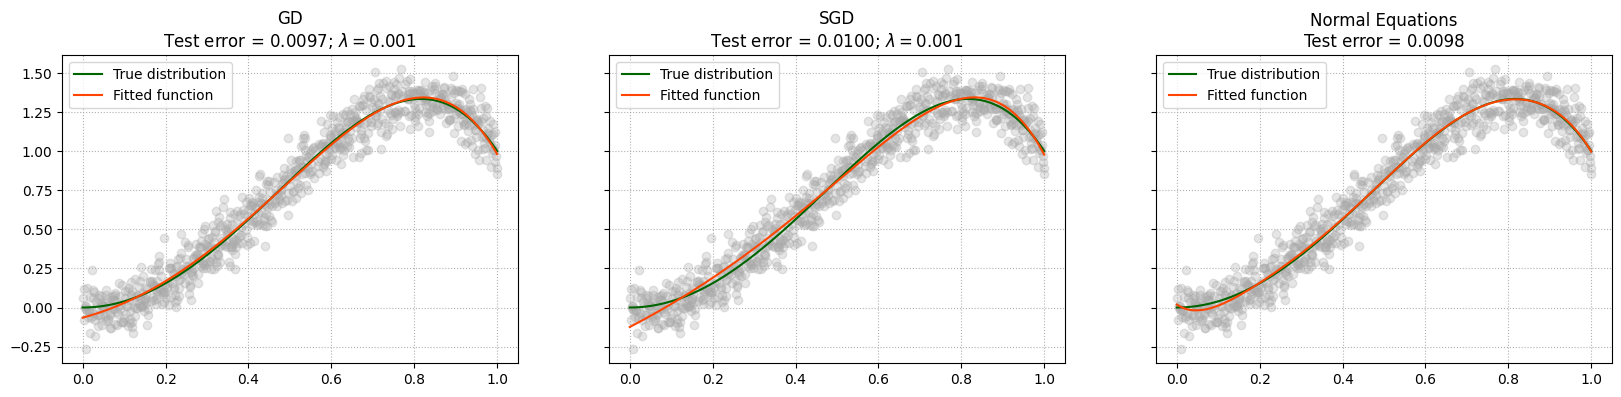

In [466]:
fig, axs = plt.subplots(figsize=(20,4) ,ncols=3, sharey=True)

ax = axs[0]
ax.set_title(f'GD\nTest error = {compute_error(Ytest, PhiX_test@theta_vals_gd[2]):.4f}; $\lambda={lambda_vals[2]}$')
ax.scatter(Xtrain, Ytrain, color='darkgrey', alpha=0.3)
ax.grid(linestyle=':')
ax.plot(X, 4*X**2 - 3*X**4, color='darkgreen', label='True distribution')
ax.plot(np.linspace(0,1, 200), vandermonde(np.linspace(0,1,200), K)@theta_vals_gd[2], color='orangered', label='Fitted function')
ax.legend()

ax = axs[1]
ax.set_title(f'SGD\nTest error = {compute_error(Ytest, PhiX_test@theta_vals_sgd[2]):.4f}; $\lambda={lambda_vals[2]}$')
ax.scatter(Xtrain, Ytrain, color='darkgrey', alpha=0.3)
ax.grid(linestyle=':')
ax.plot(X, 4*X**2 - 3*X**4, color='darkgreen', label='True distribution')
ax.plot(np.linspace(0,1, 200), vandermonde(np.linspace(0,1,200), K)@theta_vals_sgd[2], color='orangered', label='Fitted function')
ax.legend()

ax = axs[2]
ax.set_title(f'Normal Equations\nTest error = {test_err_cho:.4f}')
ax.scatter(Xtrain, Ytrain, color='darkgrey', alpha=0.3)
ax.grid(linestyle=':')
ax.plot(X, 4*X**2 - 3*X**4, color='darkgreen', label='True distribution')
ax.plot(np.linspace(0,1, 200), vandermonde(np.linspace(0,1,200), K)@theta_cholesky, color='orangered', label='Fitted function')
ax.legend()

In general GD+MAP behaves better than SGD+MAP because GD is less prone to overfitting. Normal equations method does not depend on $\lambda$ but behaves preety good. In this case normal equations method resambles true data almost perfectly. It is the same for GD that shows the lowest test error.

#### - Compare the results obtained by $\theta_{MLE}$ vs $\theta_{MAP}$.

Since MLE with $K=6$ does not overfit the data, adding regularization doesn't help the model to reach a better fitting. In general MLE works pretty good with all the three methods, while MAP doesn't work with high values of $\lambda$. With small values of $\lambda$ it achieves the same results of MLE. For all these reasons, with this dataset and with the polynomial model the best choiche is MLE.

